In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from warnings import filterwarnings
filterwarnings("ignore")

%matplotlib inline

In [95]:
df=pd.read_csv("LBW_Dataset.csv")
print("Shape:",df.shape)
df.head()

Shape: (96, 10)


,Community,Age,Weight,Delivery phase,HB,IFA,BP,Education,Residence,Result
0,1,21.0,42.0,1.0,9.2,1,1.375,5.0,1.0,0
1,1,21.0,NaN,1.0,8.8,1,1.500,5.0,1.0,0
2,1,21.0,NaN,1.0,9.2,1,2.125,5.0,1.0,0
3,1,21.0,NaN,1.0,8.0,1,1.375,5.0,1.0,0
4,1,24.0,33.0,1.0,9.3,1,1.571,5.0,1.0,0


In [96]:
nulls=df.isnull().sum()
nulls
#(nulls*100)/96

Community          0
Age                7
Weight            11
Delivery phase     4
HB                19
IFA                0
BP                15
Education          3
Residence          2
Result             0
dtype: int64

In [97]:
print("no of rows with label 1 : ", sum(df.Result == 1))
print("no of rows with label 0 : ", sum(df.Result == 0))

no of rows with label 1 :  72
no of rows with label 0 :  24


count    89.000000
mean     23.752809
std       3.321011
min      17.000000
25%      21.000000
50%      24.000000
75%      26.000000
max      38.000000
Name: Age, dtype: float64
23.770833333333332


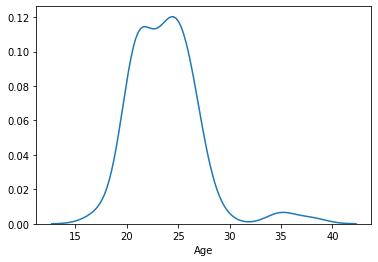

In [98]:
# AGE CLEANING & VIZ
ages=df["Age"].notnull()
age=df["Age"]
ages=age[ages]
print(ages.describe())
# plt.hist(ages,bins=20)
# plt.show()
sns.distplot(ages, hist = False, kde = True)
age.fillna(ages.median(),inplace=True)
print(df['Age'].mean())

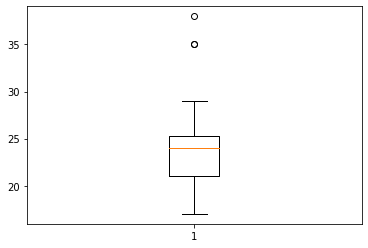

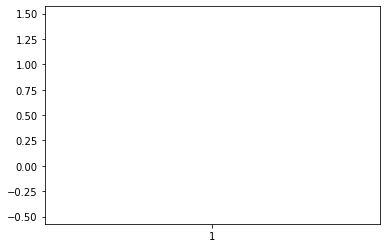

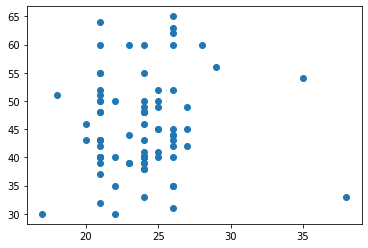

count    85.000000
mean     45.129412
std       8.215532
min      30.000000
25%      40.000000
50%      43.000000
75%      50.000000
max      65.000000
Name: Weight, dtype: float64


In [99]:
# WEIGHT CLEANING & VIZ
wts=df['Weight'].notnull()
cor_age=df.Age[wts]
cor_wts=df.Weight[wts]
plt.boxplot(df.Age)
plt.show()
plt.boxplot(df.Weight)
plt.show()
cor=np.cov(cor_age,cor_wts)
cor[0,1]/(cor_age.std()*cor_wts.std())
plt.scatter(cor_age,cor_wts)
plt.show()
print(cor_wts.describe())
df.Weight.fillna(cor_wts.mean(),inplace=True)

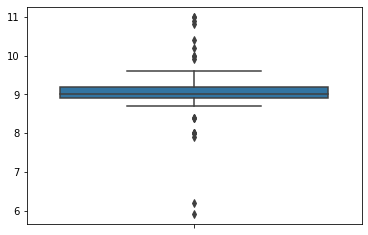

In [100]:
# HB CLEANING & VIZ
h=df['HB'].notnull()
hbs=df.HB[h].to_numpy()
lo=hbs>=8
hi=hbs<=10
hb=hbs[lo & hi]
sns.boxplot(y=hbs)
# plt.show()
#print(pd.Series(hbs).describe(),pd.Series(hb).describe())
df.HB.fillna(hb.mean(),inplace=True)

In [112]:
# BP CLEANING & VIZ
b=df['BP'].notnull()
bps=df.BP[h]
bps.describe()
df.BP.fillna(bps.mean(),inplace=True)
one_hot=pd.get_dummies(df['Community'])
df=df.drop('Community',axis=1)
df=df.join(one_hot)
df=df.reindex(columns=[1,2,3,4,'Age','Weight','HB','IFA','BP','Residence','Result'])
df.head(10)

,1,2,3,4,Age,Weight,HB,IFA,BP,Residence,Result
0,1,0,0,0,21.0,42.000000,9.200000,1,1.375000,1.0,0
1,1,0,0,0,21.0,45.129412,8.800000,1,1.500000,1.0,0
2,1,0,0,0,21.0,45.129412,9.200000,1,2.125000,1.0,0
3,1,0,0,0,21.0,45.129412,8.000000,1,1.375000,1.0,0
4,1,0,0,0,24.0,33.000000,9.300000,1,1.571000,1.0,0
5,1,0,0,0,26.0,35.000000,9.200000,1,1.571429,1.0,0
6,0,0,0,1,26.0,31.000000,9.038235,1,1.625000,1.0,0
7,1,0,0,0,22.0,30.000000,9.038235,1,1.689018,1.0,0
8,0,0,0,1,17.0,30.000000,9.000000,0,1.375000,1.0,0
9,0,0,1,0,35.0,45.129412,9.900000,1,1.571429,1.0,0


In [113]:
def sigmoid(Z):
  return 1/(np.exp(-Z)+1)
def relu(Z):
  return np.maximum(0,Z)

In [114]:
def init_parameters(dims):
  parameters={}
  for l in range(1,len(dims)):
    parameters["W"+ str(l)]=np.random.randn(dims[l],dims[l-1])*np.sqrt(2/dims[l-1])
    parameters["b"+ str(l)]=np.zeros(shape=(dims[l],1))
    #limit=np.sqrt(6/(dims[l]+dims[l-1]))
    # parameters["W"+ str(l)]=np.random.uniform(-limit,limit,size=(dims[l],dims[l-1]))
    # parameters["b"+ str(l)]=np.random.uniform(-limit,limit,size=(dims[l],1))
  return parameters

def forward_activation(A,W,b,activation):
  Z=W.dot(A)+b
  if activation=="relu":
    A_new=relu(Z)
  elif activation=="sigmoid":
    A_new=sigmoid(Z)
  cache=((A,W,b),Z)
  return A_new,cache

def forward_propogate(X,parameters):
  L=len(parameters)//2
  caches=[]
  A=X
  for l in range(1,L):
    A_prev=A
    A,cache=forward_activation(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],"sigmoid")
    caches.append(cache)
  #Last layer
  O,cache=forward_activation(A,parameters["W"+str(L)],parameters["b"+str(L)],"sigmoid")
  caches.append(cache)
  return O,caches

In [115]:
def compute_cost(O,Y,parameters,lambd):
  assert(O.shape == Y.shape)
  m=Y.shape[1]
  #print("examples:",m)
  cost=(1./m)*(-np.dot(Y,np.log(O).T)-np.dot(1-Y,np.log(1-O).T))
  cost=np.squeeze(cost)
  assert(cost.shape==())
  L=len(parameters)//2
  reg_cost=0
  for l in range(1,L+1):
    reg_cost+=(1/m) * (lambd/2) * np.sum(parameters["W"+str(l)]**2)
  return cost   #+reg_cost

In [116]:
#Back Propogation
def relu_diff(da,z):
  dz=da.copy()
  dz[z<=0]=0
  return dz
def sigmoid_diff(da,z):
  a=sigmoid(z)
  dz=da*a*(1-a)
  return dz

def backward_activation(da,cache,activation):
  cache1,cache2=cache
  lambd=0.7
  if activation=="relu":
    dz=relu_diff(da,cache2)
  elif activation=="sigmoid":
    dz=sigmoid_diff(da,cache2)
  a_prev,W,b=cache1
  m=a_prev.shape[1]
  da_prev=np.dot(W.T,dz)
  dW=np.dot(dz,a_prev.T)*(1./m)#+(lambd/m) * W
  db=np.sum(dz,axis=1,keepdims=True)*(1./m)
  return da_prev,dW,db

def back_propogate(O,Y,caches):
  grads={}
  m=O.shape[1]
  L=len(caches)
  Y=Y.reshape(O.shape)

  dO=-(np.divide(Y,O)-np.divide(1-Y,1-O))
  current_cache=caches[L-1]
  grads["dA"+str(L-1)],grads["dW"+str(L)],grads["db"+str(L)]=backward_activation(dO,current_cache,"sigmoid")

  for l in reversed(range(L-1)):
    current_cache=caches[l]
    grads["dA"+str(l)],grads["dW"+str(l+1)],grads["db"+str(l+1)]=backward_activation(grads["dA"+str(l+1)],current_cache,"sigmoid")

  return grads

In [117]:
def update_parameters(parameters,v,grads,learning_rate):
    L = len(parameters) // 2 # number of layers in the neural networks
    beta=0.9
    # Momentum update for each parameter
    for l in range(L):
        
        ### START CODE HERE ### (approx. 4 lines)
        # compute velocities
        v["dW" + str(l+1)] = beta * v["dW" + str(l+1)] + (1-beta) * grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta * v["db" + str(l+1)] + (1-beta) * grads['db' + str(l+1)]
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v['db' + str(l+1)]
        ### END CODE HERE ###
        
    return parameters, v

In [118]:
def predict(X,Y,parameters):
  #print(X[:,[0,5,10]])
  m=X.shape[1]
  n=len(parameters)//2
  predictions=np.zeros((1,m))
  prob,cache=forward_propogate(X,parameters)
  for i in range(0,prob.shape[1]):
    if prob[0][i] > 0.5:
        predictions[0][i]=1
    else:
        predictions[0][i]=0
  #print("Accuracy: "+str(np.sum(predictions[0]==Y[0])))
  print("Accuracy: "  + str(np.sum((predictions == Y)/m)))
  return predictions

In [119]:
def initialize_velocity(parameters):
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l+1)] = np.zeros_like(parameters['W' + str(l+1)])
        v["db" + str(l+1)] = np.zeros_like(parameters['b' + str(l+1)])
        ### END CODE HERE ###
        
    return v

In [120]:
def model(X,Y,layer_dims,learning_rate=0.0075,num_iterations=1500,print_cost=False):
  parameters=init_parameters(layers_dims)
  v=initialize_velocity(parameters)
  costs=[]
  for i in range(num_iterations):
    O,caches=forward_propogate(X,parameters)
    cost=compute_cost(O,Y,parameters,0.7)
    grads=back_propogate(O,Y,caches)
    parameters,v=update_parameters(parameters,v,grads,learning_rate)
    #print(O,len(O[0]))
    if print_cost and i%5000==0:
      print("Cost after",i,"iteration:",cost)
      costs.append(cost)
  plt.plot(costs)
  plt.ylabel('cost')
  plt.xlabel('iterations per 100')
  plt.title("learning rate="+str(learning_rate))
  plt.show()

  return parameters

In [121]:
data=df.to_numpy()
X_temp=data[:,[4,5,6]]
#print(X_temp[:5,:],np.sum(X_temp,axis=0))
mean=np.sum(X_temp,axis=0)/X_temp.shape[0]
X_temp-=mean
#print(X_temp[:5,:])
X_sigma=np.sum(X_temp**2,axis=0)/X_temp.shape[0]
data[:,[4,5,6]]=X_temp/np.sqrt(X_sigma)
np.savetxt("cleaned.csv",data,delimiter=',')
X=data[:,:-1]
Y=data[:,-1]
print(np.sum(Y==0),np.sum(Y==1))
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=.30,random_state=11)
print(X_train.T.shape,X_test.T.shape,Y_train.T.shape,Y_test.T.shape,X_train.T[:,50],Y_train.reshape((1,len(Y_train)))[0,50])

24 72
(10, 67) (10, 29) (67,) (29,) [ 1.          0.          0.          0.          0.07205876 -0.66746404
  0.04416435  0.          1.571       1.        ] 1.0


Cost after 0 iteration: 0.5817632643623109
Cost after 5000 iteration: 0.006809658081203503
Cost after 10000 iteration: 0.0017636140129842516
Cost after 15000 iteration: 0.000929562873947575
Cost after 20000 iteration: 0.0006129695895628574
Cost after 25000 iteration: 0.00045073157796630123
Cost after 30000 iteration: 0.0003534275115004872
Cost after 35000 iteration: 0.00028910352570005545
Cost after 40000 iteration: 0.0002436691967986087
Cost after 45000 iteration: 0.00020999831443987253
Cost after 50000 iteration: 0.0001841194982873539
Cost after 55000 iteration: 0.00016365299595019715
Cost after 60000 iteration: 0.0001470900847943425
Cost after 65000 iteration: 0.00013343010716136352
Cost after 70000 iteration: 0.00012198439057218031
Cost after 75000 iteration: 0.00011226413374808283


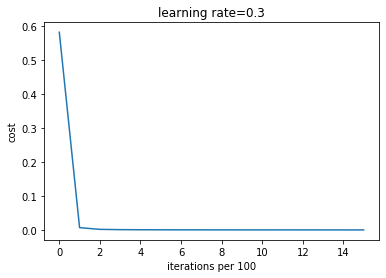

In [122]:
layers_dims=(10,10,3,1)
parameters=model(X_train.T,Y_train.reshape((1,len(Y_train))),layers_dims,learning_rate=0.3,num_iterations=80000,print_cost=True)

In [123]:
predict(X_train.T,Y_train.reshape((1,len(Y_train))),parameters)

Accuracy: 1.0


array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1.]])

In [124]:
predict(X_test.T,Y_test.reshape((1,len(Y_test))),parameters)

Accuracy: 0.689655172413793


array([[0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.]])

In [125]:
parameters

{'W1': array([[ 8.35920194e-01,  5.40464982e-01, -1.80396272e-01,
          1.14988026e+00, -3.24049618e-01, -3.51814685e+00,
          5.03911127e-01, -2.19158920e-01,  1.43439295e-01,
         -4.23857704e-01],
        [ 1.67181176e+00, -5.08460254e-01, -1.30148698e+00,
          1.90753765e+00, -4.08461837e+00,  7.72482400e+00,
          1.26961025e+00, -1.81661255e+00, -1.24011458e+00,
          1.50013875e+00],
        [-1.99225444e+00, -2.85375714e-01,  7.92078859e-01,
         -1.38078577e+00,  1.93317657e+00, -2.67668899e+00,
         -1.60844185e+00,  1.24565340e+00,  1.17601490e-01,
         -2.45040767e+00],
        [ 9.34238875e-01,  4.73937512e-01, -2.40993558e-01,
         -5.84167198e-01, -5.04022838e-01,  8.27760783e-01,
         -3.84730557e-01,  4.31577159e-01, -8.78985961e-03,
         -6.76179100e-02],
        [-2.80784965e-01, -2.57138008e-01,  1.07316518e-01,
          2.88103355e-01,  1.60795252e+00,  3.10163192e-01,
         -4.98518598e-03,  7.06300494e-01,  1.